In [1]:
import sys
import importlib
import pickle

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data analysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# pytorch specific
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# project specific
sys.path.append('../')
from src import config
from src.utils import visualisation, benchmark, helpers, monitoring
from src.models import torch_CVAE, torch_CVAE_1


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

pd.options.display.width = 1000
DEVICE = torch.device(config["DEVICE"])

In [2]:
importlib.reload(helpers)

with open('../workfiles/BRCA_ds.pkl', 'rb') as f:
    data, metadata = pickle.load(f)

feature_num = len(metadata["feature_names"])
print(feature_num)

10277


In [3]:
importlib.reload(helpers)
data_set, dataloader = helpers.format_dataset(data, metadata, 0.01)

(1231, 10277)
(1231, 1, 10277)
train data: 1231


In [19]:
importlib.reload(torch_CVAE_1)

latent_dim = 64
model = torch_CVAE_1.Autoencoder(
    shape = feature_num,
    dropout = 0.2,
    latent_dim = latent_dim,
    is_variational = False,
    use_convolution= False,
    )
#model.add_self_attention(0.4)
#model.add_attention()
#model.to(DEVICE)


optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad=False)
train_res_recon_error = []
perplexities = []
frames = []

#benchmark.count_parameters(model)
#Trainable parameters: 21255169




model.to(DEVICE)
print("")


In [20]:
importlib.reload(monitoring)
monitor = monitoring.Monitor(model, dataloader, label = metadata["subtypes"])

callbacks = monitor.callbacks

0.0001


  0%|          | 9/10000 [00:18<5:49:57,  2.10s/it]

torch.Size([1, 10277])
(1, 10277)


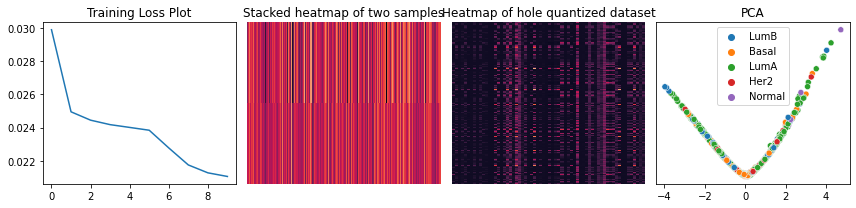

  0%|          | 10/10000 [00:22<6:57:22,  2.51s/it]

torch.Size([1, 10277])
(1, 10277)


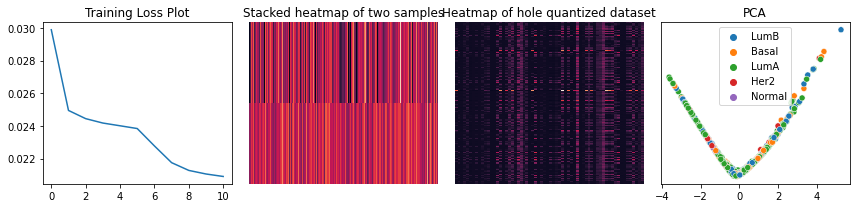

  0%|          | 12/10000 [00:28<7:20:30,  2.65s/it]

torch.Size([1, 10277])
(1, 10277)


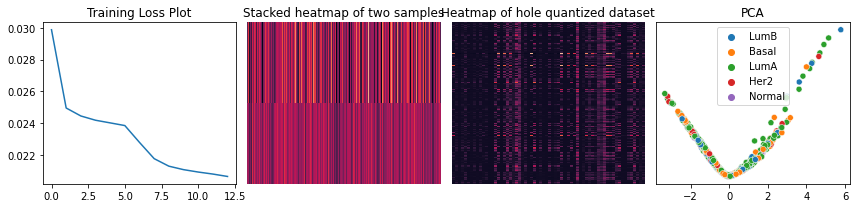

  0%|          | 14/10000 [00:33<6:57:01,  2.51s/it]

torch.Size([1, 10277])
(1, 10277)


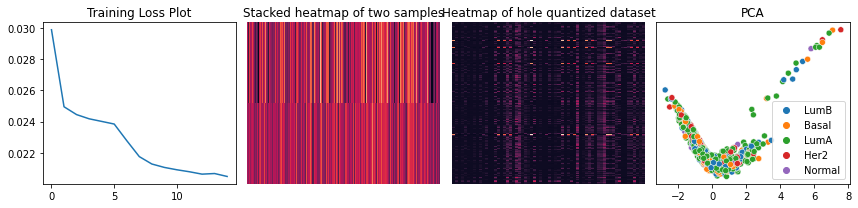

  0%|          | 16/10000 [00:38<6:42:09,  2.42s/it]


KeyboardInterrupt: 

In [21]:
EPOCH = 10000

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr= 1e-5)
print(optimizer.param_groups[0]['lr'])

model.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    
    # Training loop
    for _, inputs in enumerate(dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        # Compute the VAE loss or standard loss
        if model.is_variational:
            outputs, mu, log_var = model(inputs)
            reconstruction_loss = F.mse_loss(outputs, inputs)
            kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconstruction_loss + (1 * kld)
        else:
            outputs = model(inputs)
            loss = F.mse_loss(outputs, inputs)
        
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    monitor.append_loss(train_loss)
    callbacks(epoch)


print(optimizer.param_groups[0]['lr'])
#RuntimeError: The size of tensor a (10279) must match the size of tensor b (10277) at non-singleton dimension 2


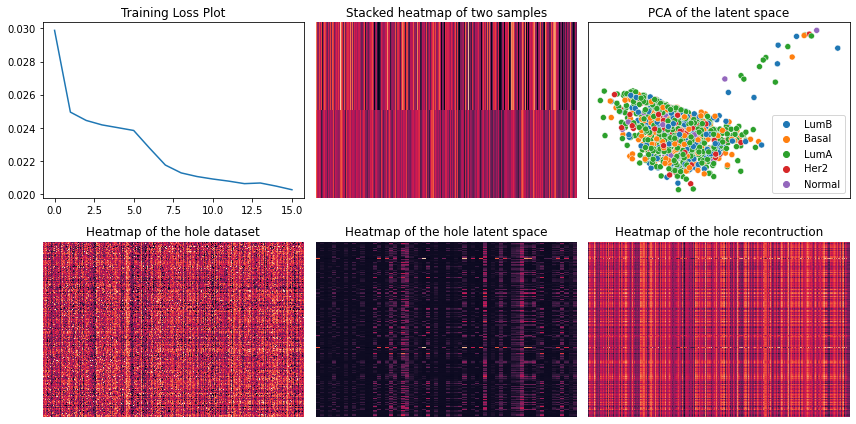

In [23]:
importlib.reload(visualisation)
visualisation.post_training_viz(data, dataloader, model, DEVICE, monitor.train_res_recon_error, labels = metadata["subtypes"])

In [64]:
# sometimes you just want a sigle PCA

importlib.reload(helpers)
encode_out, reconstruction_out = helpers.encode_recon_dataset(dataloader, model, DEVICE)

# PCA of the latent space
pca = PCA(n_components=2)
pca.fit(encode_out)
pca_result = pca.transform(encode_out)

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=metadata["subtypes"])


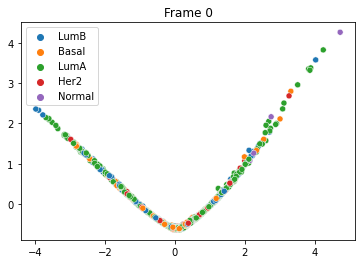

In [26]:
# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Define an update function for the animation
def update(frame):
    ax.clear()
    ax.set_title(f'Frame {frame}')
    
    # Get the PCA result for the current frame
    pca_result = monitor.frames[frame]
    
    # Scatter plot of PCA results with color based on index
    sns.scatterplot(x=pca_result[:, 1], y=pca_result[:, 2], hue=metadata["subtypes"])


# Create the animation
ani = FuncAnimation(fig, update, frames=len(monitor.frames), repeat=True)

# Display the animation as HTML
HTML(ani.to_jshtml())

In [ ]:
if model.is_variational:
    if model.use_convolution:
        ani.save('../img/GDS_pca_convVAE_0.mp4', writer='ffmpeg')
    else:
        ani.save('../img/GDS_pca_VAE_0.mp4', writer='ffmpeg')

else:
    if model.use_convolution:
        ani.save('../img/GDS_pca_convAE_0.mp4', writer='ffmpeg')
    else:
        ani.save('../img/GDS_pca_AE_0.mp4', writer='ffmpeg')


In [45]:
torch.save(model, "../workfiles/torch_convAE_GDS_0")